# Install the required libraries 

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load Data

In [30]:
df = pd.read_csv('train.csv')

* Display column names and data types

In [31]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [32]:
# Initial exploration
print("First 5 rows:")
print(df.head())
print("\nDataset info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())

First 5 rows:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   200

# Bathroom feature engineering

In [33]:
df['TotalBath'] = df['FullBath'] + (df['HalfBath'] * 0.5)

# Data Visualisation 

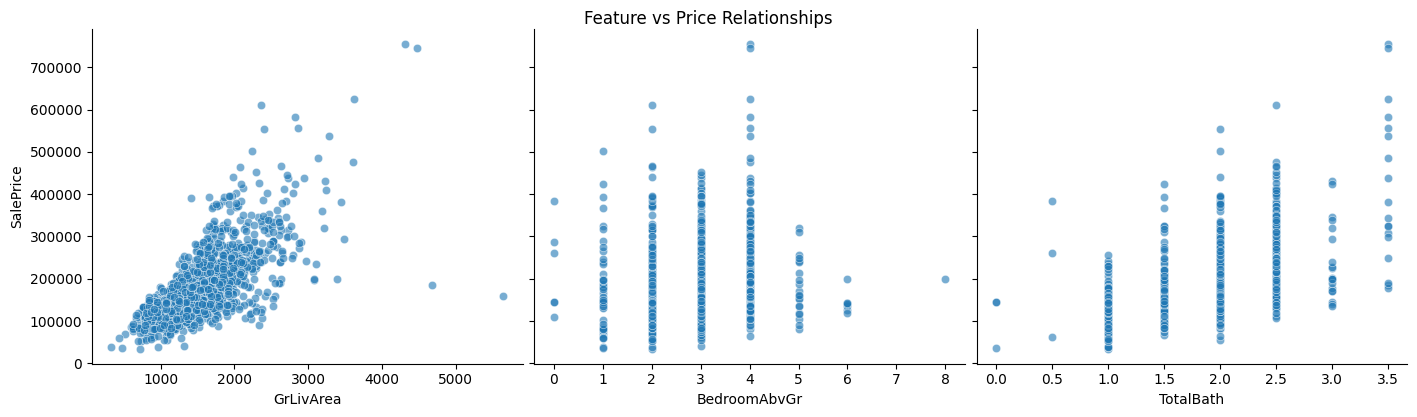

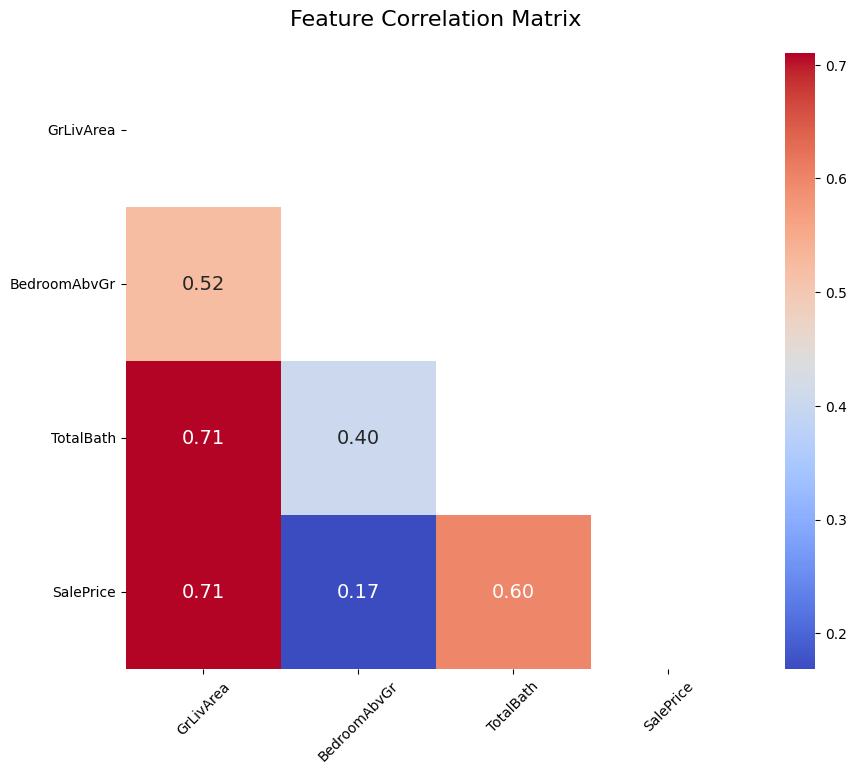

In [34]:
# Data visualization
sns.pairplot(df, x_vars=['GrLivArea', 'BedroomAbvGr', 'TotalBath'], 
             y_vars='SalePrice', height=4, aspect=1.2, plot_kws={'alpha':0.6})
plt.suptitle('Feature vs Price Relationships', y=1.02)
plt.show()

# Correlation analysis
plt.figure(figsize=(10, 8))
corr_matrix = df[['GrLivArea', 'BedroomAbvGr', 'TotalBath', 'SalePrice']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", 
            annot_kws={"size": 14}, mask=np.triu(np.ones_like(corr_matrix, dtype=bool)))
plt.title("Feature Correlation Matrix", pad=20, fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# Check for missing values
* Handle missing values (if any)
* Add any necessary data cleaning steps here based on missing values output


In [35]:
# Add this after your initial missing values check
print("\nMissing Values in Selected Features:")
print(df[['GrLivArea', 'BedroomAbvGr', 'FullBath', 'HalfBath', 'SalePrice']].isnull().sum())



Missing Values in Selected Features:
GrLivArea       0
BedroomAbvGr    0
FullBath        0
HalfBath        0
SalePrice       0
dtype: int64


In [36]:
# Add this data cleaning step (even though sum is 0, good practice)
df = df.dropna(subset=['GrLivArea', 'BedroomAbvGr', 'FullBath', 'HalfBath', 'SalePrice'])


# checking on the cols that we need ONLY

* we notice that despite some missing data in the dataset, however the feature we need in order to train/test 

# Model Creation 

In [44]:
# Feature selection
features = df[['GrLivArea', 'BedroomAbvGr', 'TotalBath']]
target = df['SalePrice']

# Train-test split (fixed with proper parameters)
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    target, 
    test_size=0.2, 
    random_state=42
)

# Verify split sizes
print(f"\nTraining samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Training samples: 1168
Testing samples: 292


In [38]:
# Model training
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [39]:
# Model evaluation
y_pred = model.predict(X_test)

In [40]:
# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [41]:
print("\nModel Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): ${mae:,.2f}")
print(f"Mean Squared Error (MSE): ${mse:,.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f}")
print(f"R-squared (R²): {r2:.4f}")


Model Evaluation Metrics:
Mean Absolute Error (MAE): $36,569.64
Mean Squared Error (MSE): $2,848,523,443.42
Root Mean Squared Error (RMSE): $53,371.56
R-squared (R²): 0.6286


In [42]:
# Coefficients analysis
coefficients = pd.DataFrame({
    'Feature': features.columns,
    'Coefficient': model.coef_,
    'Impact per Unit': [f"${c:,.2f}" for c in model.coef_]
})
print("\nFeature Coefficients:")
print(coefficients)
print(f"\nIntercept: ${model.intercept_:,.2f}")


Feature Coefficients:
        Feature   Coefficient Impact per Unit
0     GrLivArea    100.636895         $100.64
1  BedroomAbvGr -26645.532516     $-26,645.53
2     TotalBath  27083.207713      $27,083.21

Intercept: $56,862.58


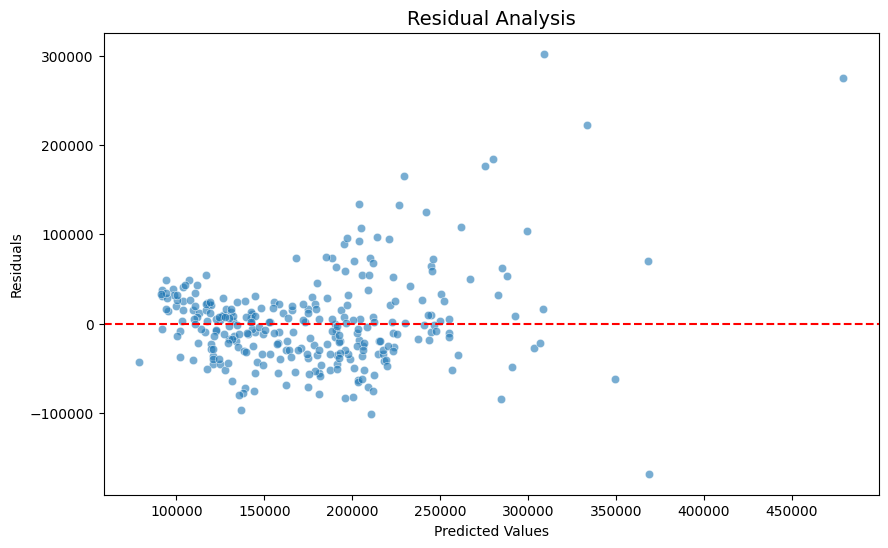

In [43]:
# Residual analysis
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Analysis', fontsize=14)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()